In [4]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

import utils.luigi_wrapper as luigi
from utils.utils import *

from preprocess.questions_label_extraction import QuestionsLabelExtractionTask
from questions_model.create_predictions import QuestionsMakePredictionsTask
from preprocess.train_test_split import TrainTestSplitTask
from preprocess.data_tokenization import DataTokenizationTask
from preprocess.feature_selection import FeatureSelectionTask


from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, f1_score

from IPython.display import display

In [17]:
pd.set_option('max_rows', 70)

In [267]:
def get_prior(y):
    num_of_pages = y.shape[0]
    num_of_classes = y.shape[1]

    p_ij = np.zeros((num_of_classes, num_of_classes))
    for lst in y:
        for i in range(num_of_classes):
            for j in range(num_of_classes):
                p_ij[i, j] += (lst[i] * lst[j]) / num_of_pages
    return p_ij

def get_mutual_information(p_ij, nan=0, neginf=-5):
    E = np.zeros(p_ij.shape)
    for i in range(p_ij.shape[0]):
        for j in range(p_ij.shape[0]):
            E[i, j] = p_ij[i,j] * np.log(p_ij[i,j] / (p_ij[i, i] * p_ij[j, j]))
    E_filled = - np.nan_to_num(E, nan=nan, neginf=neginf)
    return E_filled

def run_prior_on_prediction_old(p_ij, prediction):
    sum_prediction = sum(prediction)
    priored_prediction = []
    for i in range(len(prediction)):
        p_i_new = 0
        Z = 0
        for j in range(len(prediction)):
            
            p_i_new += prediction[i] * (prediction[j] * p_ij[i,j] + (1-prediction[j]) * (p_ij[i,i] - p_ij[i,j]))
            Z += p_ij[i,i]

        p_i_new /= Z


        priored_prediction.append(p_i_new)
    return priored_prediction

In [268]:
def run_prior_on_prediction(p_ij, prediction):
    sum_prediction = sum(prediction)
    priored_prediction = []
    for i in range(len(prediction)):
        p_i_new = 0
        Z = 0
        for j in range(len(prediction)):
            conn_strength = np.log(p_ij[i,j] / (p_ij[i, i] * p_ij[j, j])) if p_ij[i,j] > 0 else -5.

            prior_shift = p_ij[i, j] * conn_strength # * sum_prediction
            
            mone = prediction[i] * (prediction[j] * p_ij[i,j] + (1-prediction[j]) * (p_ij[i,i] - p_ij[i,j]))
            mechane = mone + (1-prediction[i]) * (prediction[j] * (p_ij[j,j] - p_ij[i,j]) + (1-prediction[j]) * (1 - p_ij[i,i] - p_ij[i,j] + p_ij[i,j]))

            p_i_new += mone / mechane
            Z += p_ij[i,i]

        p_i_new /= Z

        priored_prediction.append(p_i_new)
    return priored_prediction

In [272]:
def get_y_by_thresh(y_proba, thresh= 0.5):
    return (y_proba > thresh).astype(int)

def get_thresh(y_true, y_pred, n_thers = 600, plot=False):
    thresholds = [n / n_thers for n in list(range(1, n_thers, 1))]
    f1_scores = [f1_score(y_true, get_y_by_thresh(y_pred, thresh), average = 'macro') for thresh in thresholds]
    
    if plot:
        plt.plot(thresholds, f1_scores)
        plt.show()
    
    return thresholds[np.argmax(f1_scores)]

def get_y(y_test, y_proba):
    y = []
    for c in range(y_proba.shape[1]):
        y_proba_c = y_proba[:, c]
        y_test_c = y_test[:, c]
        y.append(get_y_by_thresh(y_proba_c, get_thresh(y_test_c, y_proba_c)))
    return np.array(y).T

## Read Data

In [273]:
X = read_data(get_file_path('tokenized_array.pickle', 'data'))
y = read_data(get_file_path('question_labels.pickle', 'data'))
train_test_split = read_data(get_file_path('train_test_dict.pickle', 'data'))
train_indices = train_test_split['train_indices']
test_indices = train_test_split['test_indices']

model = read_data(get_file_path('best_estimator.pickle', 'question_model'))
y_pred = read_data(get_file_path('y_pred.pickle', 'question_model'))

X.shape, y.shape, y_pred.shape, len(train_indices)

((6221, 4328), (6221, 59), (6221, 59), 4976)

In [274]:
X_train = X.iloc[train_indices]
y_train = y.iloc[train_indices]

X_test = X.iloc[test_indices]
y_test = y.iloc[test_indices]

## Get Prior

In [276]:
p_ij = get_prior(y.iloc[train_indices].values)

## Train Model

In [288]:
from lightgbm import LGBMClassifier
from sklearn.multiclass import OneVsRestClassifier
model = OneVsRestClassifier(LGBMClassifier(class_weight = 'balanced'), n_jobs=-2)
model.fit(X_train.to_numpy(), y_train)

OneVsRestClassifier(estimator=LGBMClassifier(boosting_type='gbdt',
                                             class_weight='balanced',
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=None, reg_alpha=0.0,
                                             reg_lambda=0.0, silent=True,
                                             subsample=1.0,
                                             subsample_for_bin=200000,
             

In [289]:
y_pred_proba = model.predict_proba(X_test)

In [290]:
#y_pred_proba = y_pred

In [291]:
#print(classification_report(y_test, np.round(y_pred_proba)))

## Priored Predictions

In [292]:
E = get_mutual_information(p_ij)
T = minimum_spanning_tree(E)

C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [347]:
def theta(p_ij, i, j, i_val, j_val):
    if i_val == 1 and j_val == 1:
        return p_ij[i,j] / (p_ij[i,i] * p_ij[j,j])
    elif ival == 1 and j_val == 0:
        return (p_ij[i,i] - p_ij[i,j]) / (p_ij[i,i] * (1 - p_ij[j,j]))
    elif ival == 0 and j_val == 1:
        return (p_ij[j,j] - p_ij[i,j]) / (p_ij[j,j] * (1 - p_ij[i,i]))
    elif ival == 0 and j_val == 1:
        return (1 - p_ij[j,j] - p_ij[i,i] + p_ij[i,j]) / ((1 - p_ij[j,j]) * (1 - p_ij[i,i]))


def message(p_ij, T, prediction, i, parent, parent_val):
    N = []
    for j in range(len(prediction)):
        if (T[i,j] != 0 or T[j,i] != 0) and j != parent and j != i:
            N.append(i)
    if len(N) > 0:
        m1 = theta(p_ij, i, parent, 1, parent_val) * prediction[j] * sum([message(p_ij, T, prediction, n, i, 1) for n in N])
        m0 = theta(p_ij, i, parent, 0, parent_val) * (1 - prediction[j]) * sum([message(p_ij, T, prediction, n, i, 0) for n in N])
    else:
        m1 = theta(p_ij, i, parent, 1, parent_val) * prediction[j]
        m0 = theta(p_ij, i, parent, 0, parent_val) * (1 - prediction[j])
    
    return m1 + m0
    
            

In [348]:
def run_prior_on_prediction(p_ij, T, prediction):
    sum_prediction = sum(prediction)
    priored_prediction = []
    
    for i in range(len(prediction)):
        p_i_new = 0
        N = []
        for j in range(len(prediction)):
            if T[i,j] == 0 and T[j,i] == 0:
                N.append(j)
        messages1 = [message(p_ij, T, prediction, n, i, 1) for n in N]
        messages0 = [message(p_ij, T, prediction, n, i, 0) for n in N]
        
        p_i1 = prediction[i] * np.prod(messages1)
        p_i0 = (1 - prediction[i]) * np.prod(messages0)

            
            
        p_i_new += p_i1 / (p_i1 + p_i0)

        priored_prediction.append(p_i_new)
    return priored_prediction

In [349]:
E = get_mutual_information(p_ij)
T = minimum_spanning_tree(E).todense()
y_pred_after_prior_proba = np.array([run_prior_on_prediction(p_ij, T, p) for p in y_pred_proba])

C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


RecursionError: maximum recursion depth exceeded while calling a Python object

In [299]:
y_pred = get_y(y_test.to_numpy(), y_pred_proba)
y_pred_after_prior = get_y(y_test.values, y_pred_after_prior_proba)

## Scores Comparison

In [300]:
def get_classification_df(y_test, y_pred):
    return pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, target_names=y.columns)).T

display(get_classification_df(y_test, y_pred).join(get_classification_df(y_test, y_pred_after_prior), rsuffix = '_prior'))

C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support,precision_prior,recall_prior,f1-score_prior,support_prior
agent,0.583333,0.700000,0.636364,20.0,0.583333,0.700000,0.636364,20.0
album,0.975610,0.930233,0.952381,43.0,0.975610,0.930233,0.952381,43.0
alia,0.365931,0.485356,0.417266,239.0,0.367925,0.489540,0.420108,239.0
alma_mat,0.666667,0.166667,0.266667,12.0,0.666667,0.166667,0.266667,12.0
alt,0.588235,0.294118,0.392157,34.0,0.523810,0.323529,0.400000,34.0
artist,0.990654,0.981481,0.986047,108.0,0.990654,0.981481,0.986047,108.0
associated_act,0.891350,0.939933,0.914997,899.0,0.891579,0.942158,0.916171,899.0
award,0.300000,0.375000,0.333333,8.0,0.300000,0.375000,0.333333,8.0
b-side,0.500000,0.538462,0.518519,13.0,0.600000,0.461538,0.521739,13.0
background,0.955179,0.969666,0.962368,989.0,0.956044,0.967644,0.961809,989.0


In [301]:
print(f1_score(y_test, y_pred, average = 'macro'))
print(f1_score(y_test, y_pred_after_prior, average = 'macro'))

0.6880538600745464
0.6887432688084757


In [ ]:
print(classification_report(y_pred, y_pred_after_prior, target_names=y.columns))

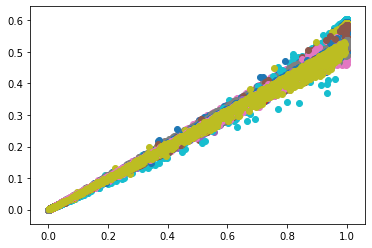

In [302]:
for c in range(y.shape[1]):
    plt.scatter(y_pred_proba[:, c], y_pred_after_prior_proba[:, c])
plt.show()

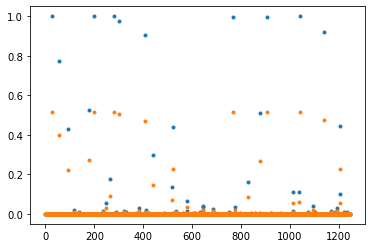

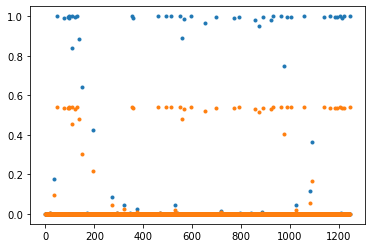

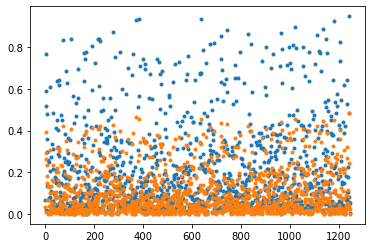

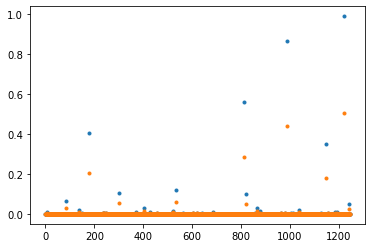

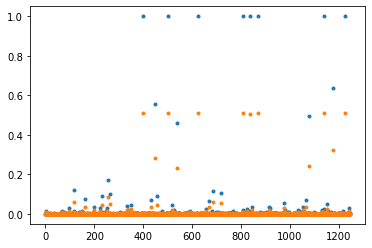

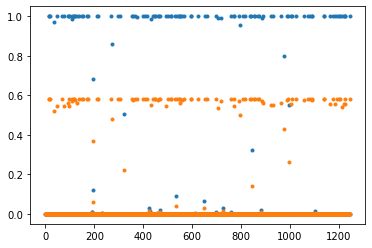

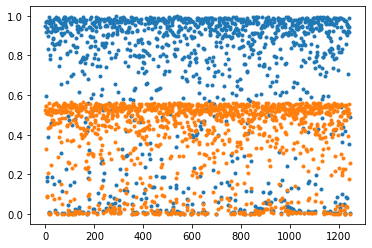

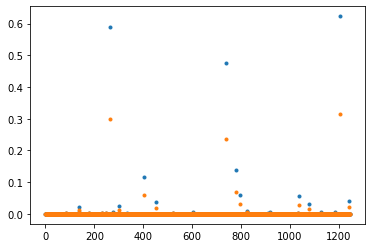

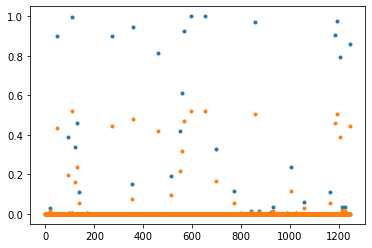

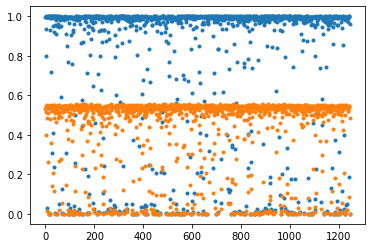

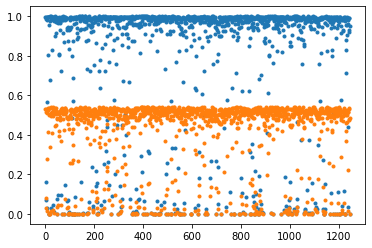

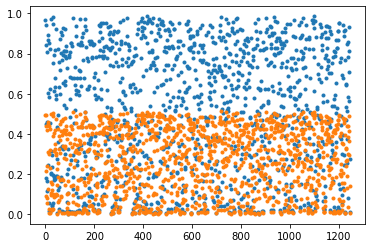

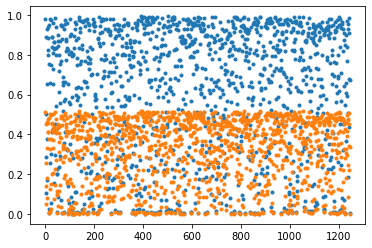

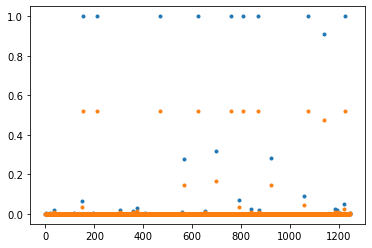

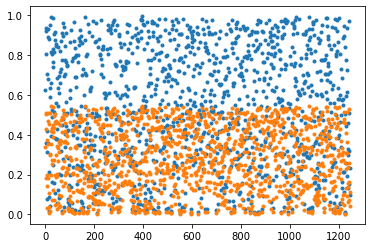

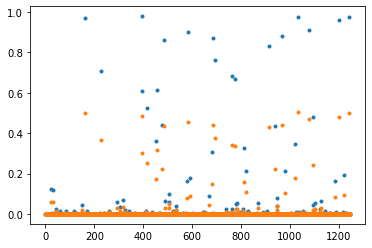

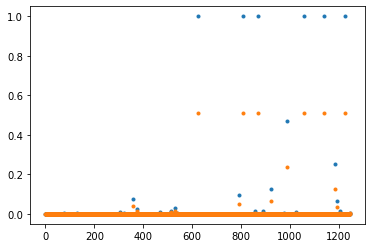

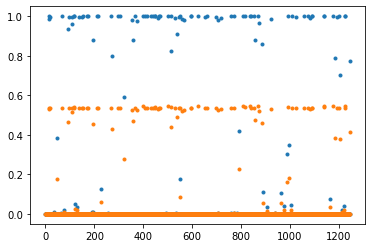

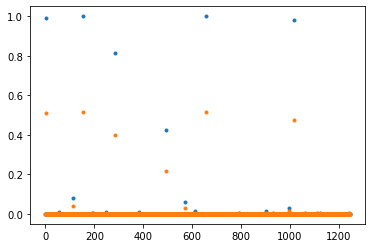

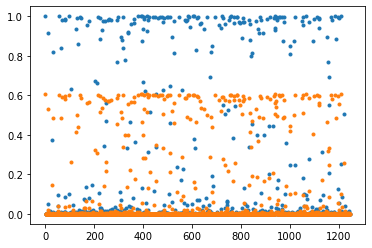

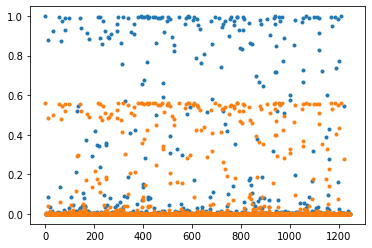

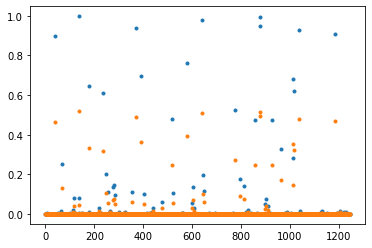

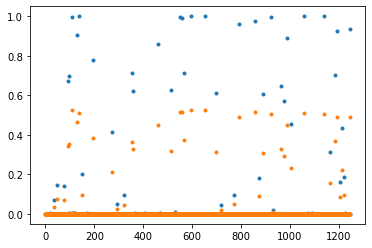

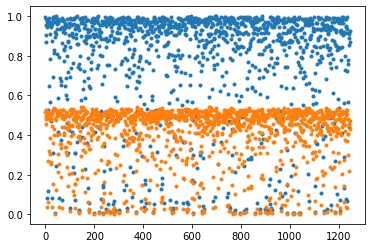

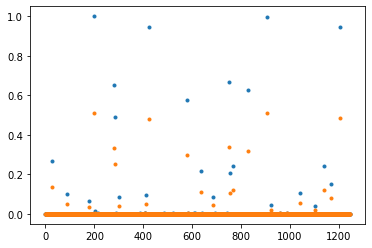

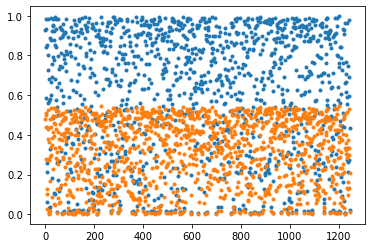

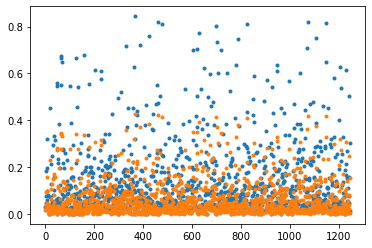

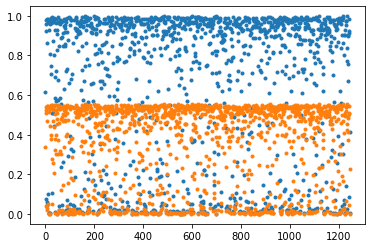

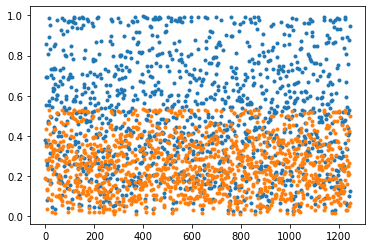

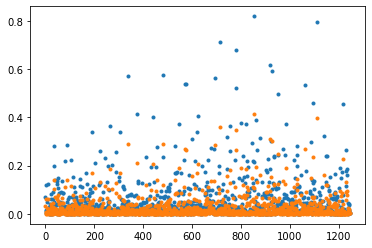

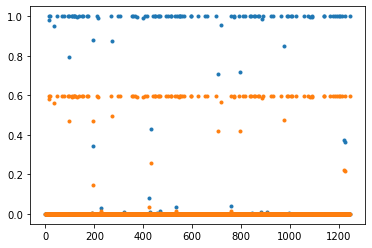

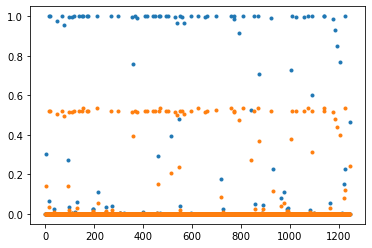

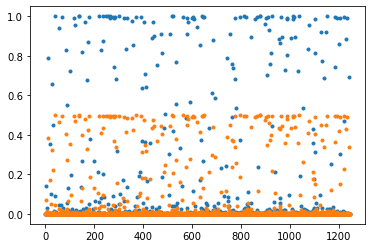

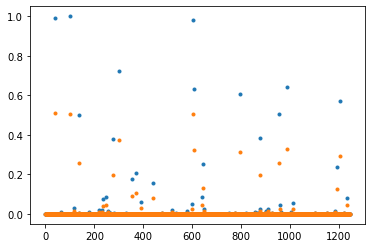

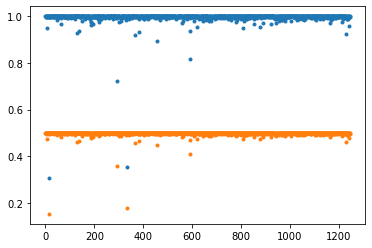

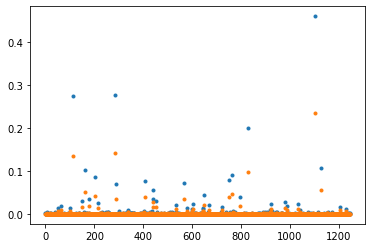

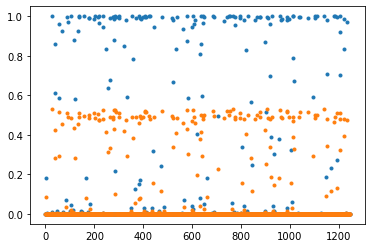

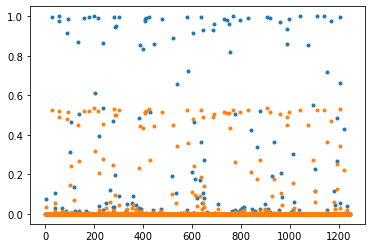

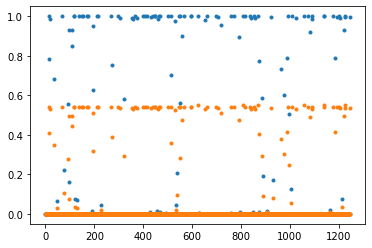

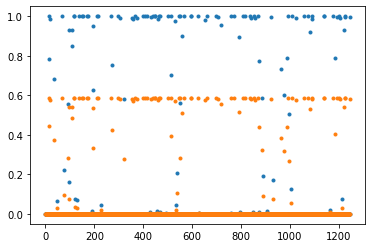

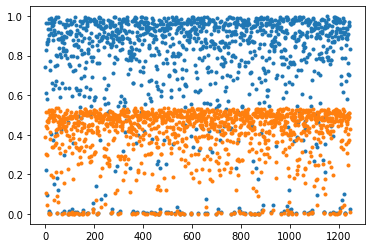

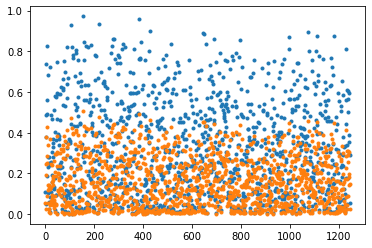

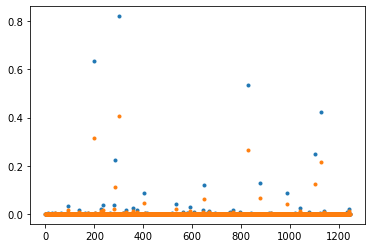

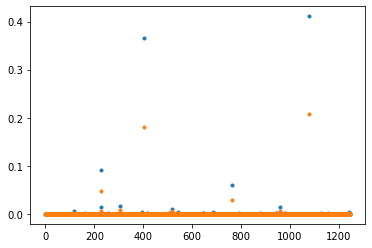

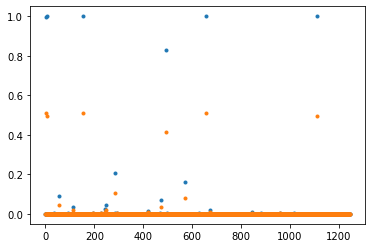

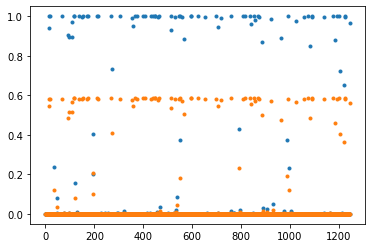

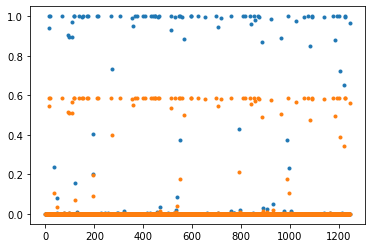

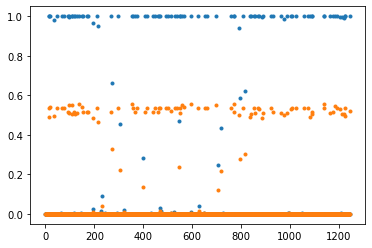

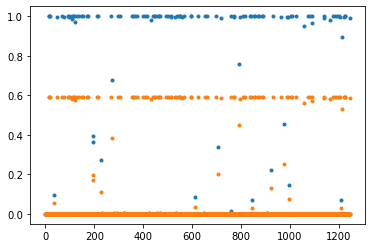

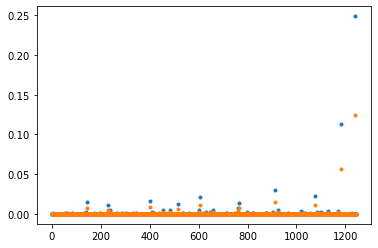

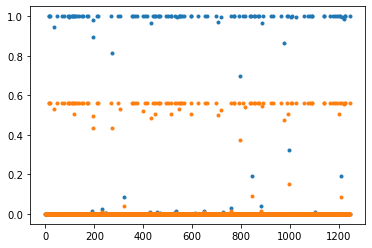

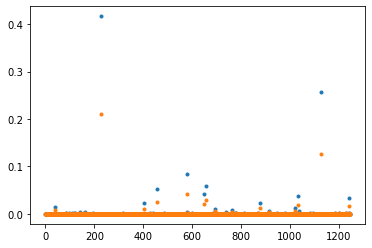

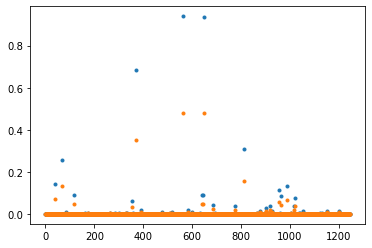

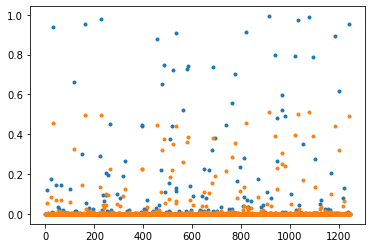

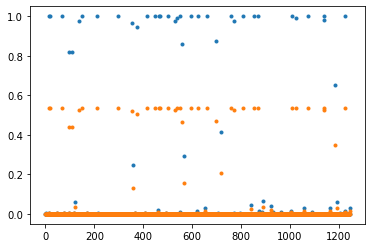

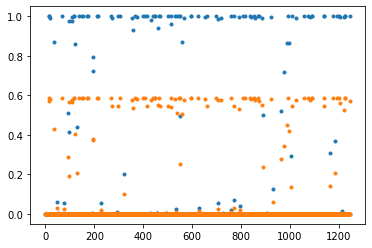

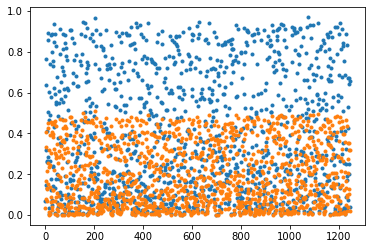

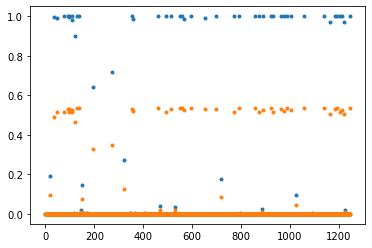

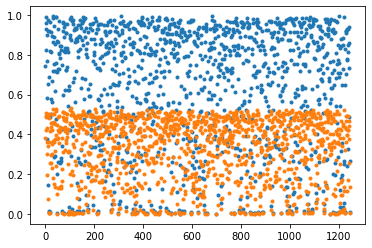

In [303]:
for c in range(y.shape[1]):
    plt.plot(y_pred_proba[:, c], '.')
    plt.plot(y_pred_after_prior_proba[:, c], '.')
    plt.show()

In [304]:
label_count = len(y.columns)

In [306]:
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx

C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


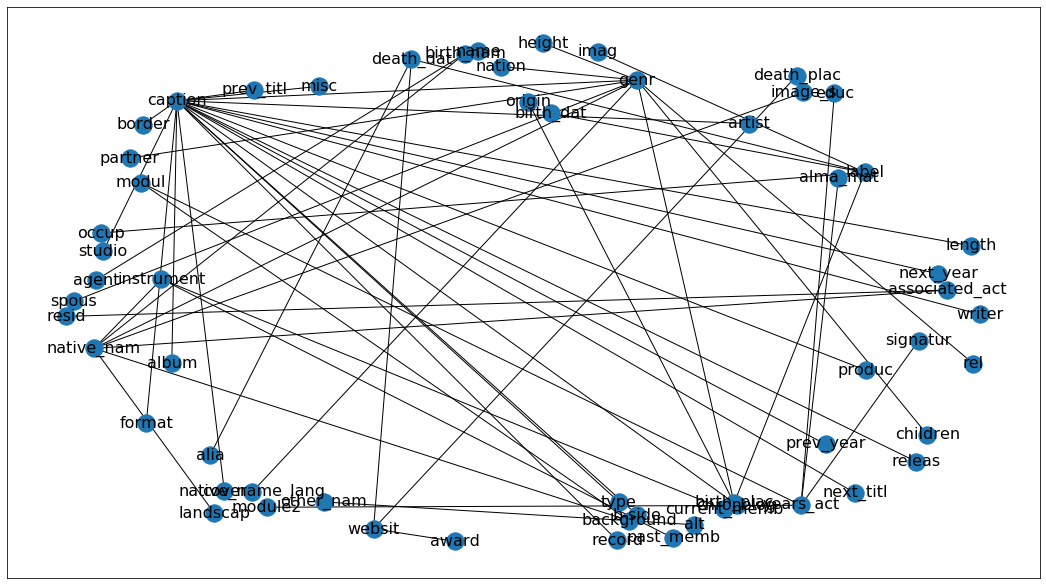

In [309]:
T = minimum_spanning_tree(get_mutual_information(p_ij)).todense()
G = nx.Graph(T, nodes=y.columns)
G = nx.relabel_nodes(g, {i: c for i,c in zip(range(y.shape[1]), y.columns)})
nx.draw_networkx(G, cmap=plt.get_cmap('jet'), with_labels=True,font_size=16, pos=nx.fruchterman_reingold_layout(G))
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

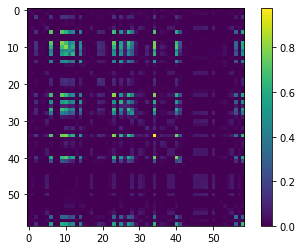

In [330]:
plt.imshow(p_ij)
plt.colorbar()

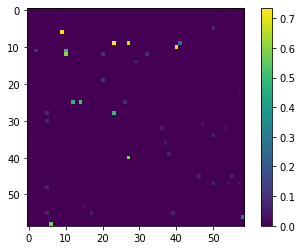

In [329]:
plt.imshow(np.array((T != 0) * 1.) * p_ij)
plt.colorbar()

C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\Users\Aviv\Anaconda3\envs\research_env\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


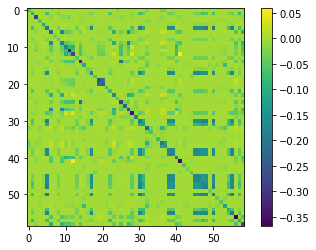

In [332]:
E = get_mutual_information(p_ij)
plt.imshow(E)
plt.colorbar()

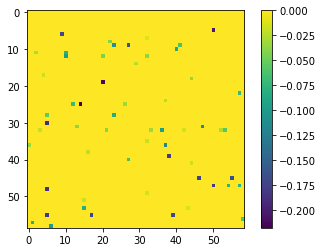

In [333]:
plt.imshow(np.array((T != 0) * 1.) * E)
plt.colorbar()